## Import Libraries

In [1]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [2]:
df = pd.read_csv("./DF_Classification_Lower.csv")

In [3]:
df.shape

(3619, 19)

In [4]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,28,Manchester United,Attack-RightWinger,174.0,21.0,34,0.0,0.087379,0.262136,0.0,0.0,0.0,0.0,1030,90,15,1,3000000,7000000
1,61,Leicester City,Defender Centre-Back,199.0,30.0,25,0.0,0.000000,0.245734,0.0,0.0,0.0,0.0,1465,241,35,0,5000000,20000000


In [5]:
df.drop(columns='Unnamed: 0' , inplace = True)
# df.drop(columns='name' , inplace = True)

## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [6]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value


In [7]:
# Completeness
df.isnull().sum()

team                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
dtype: int64

In [8]:
# Accurecy types
df.dtypes

team                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
dtype: object

In [9]:
numeric_col = [col for col in df.columns if df[col].dtype != "object"]
categorical_col = [col for col in df.columns if df[col].dtype == "object"]

In [10]:
for i in categorical_col:
    print(df[i].value_counts())

team
Daegu FC                   33
FC Seoul                   33
Daejeon Hana Citizen       30
Suwon Samsung Bluewings    30
Jeonbuk Hyundai Motors     29
                           ..
Feyenoord Rotterdam         1
CF América                  1
CSKA Moscow                 1
West Bromwich Albion        1
Manchester United           1
Name: count, Length: 364, dtype: int64
position
Defender Centre-Back          610
Attack Centre-Forward         434
midfield-CentralMidfield      395
Defender Right-Back           328
midfield-DefensiveMidfield    304
Defender Left-Back            291
midfield-AttackingMidfield    290
Attack-RightWinger            267
Attack-LeftWinger             264
Goalkeeper                    226
midfield-LeftMidfield          46
midfield                       43
midfield-RightMidfield         41
Attack                         30
Attack-SecondStriker           29
Defender                       21
Name: count, dtype: int64


#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [11]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,Manchester United,Attack-RightWinger,174.0,21.0,34,0.0,0.087379,0.262136,0.0,0.0,0.0,0.0,1030,90,15,1,3000000,7000000
1,Leicester City,Defender Centre-Back,199.0,30.0,25,0.0,0.000000,0.245734,0.0,0.0,0.0,0.0,1465,241,35,0,5000000,20000000


In [12]:
categorical_col = ['team']

In [13]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_col)

In [14]:
df.shape

(3619, 381)

In [15]:
encoder = LabelEncoder()
df['position'] = encoder.fit_transform(df['position'])  

#### 3. Feature selection

In [16]:
# sns.heatmap(df.corr(), annot=True);

In [17]:
correlation = df.corr()
correlation['position'].sort_values(ascending=False)

position                                 1.000000
goals conceded                           0.057594
team_Grêmio Foot-Ball Porto Alegrense    0.040090
team_Bayer 04 Leverkusen                 0.038487
team_Nagoya Grampus                      0.036973
                                           ...   
team_MKE Ankaragücü                     -0.045261
appearance                              -0.099701
assists                                 -0.112057
height                                  -0.115026
goals                                   -0.293572
Name: position, Length: 381, dtype: float64

In [18]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['position']) > threshold]['position'].index
selected_features

Index(['position', 'goals'], dtype='object')

#### 4. Prepare train and test data

In [19]:
# Prepare data
X = df.drop(['position'], axis=1)
y = df['position']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
X.shape

(3619, 380)

## Buliding the Model

In [21]:
model = SVC()

In [22]:
param_grid = {
    'kernel': [
             # 'linear',
               'rbf',
             # 'poly'
              ],   # Regularization strength
    'C':[0, 2, 5, 10, 15, 20, 25],
    'gamma': [1,2,6]
}
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

## Train the Model

In [23]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0, 2, 5, 10, 15, 20, 25], 'gamma': [1, 2, 6],
                         'kernel': ['rbf']},
             scoring='f1_macro', verbose=1)

In [24]:
grid_search.best_params_

{'C': 2, 'gamma': 1, 'kernel': 'rbf'}

In [25]:
model = grid_search.best_estimator_

## Test the Model

In [26]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Evaluating the Model 

In [27]:
# our benchmark model
base_model = round(df['position'].value_counts()[1]/df.shape[0]*100, 2)
base_model

11.99

1. Accuracy

In [28]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy*100

17.265193370165747

In [29]:
y_pred_train = model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_train)
accuracy*100

98.1692573402418

2. Precision

In [30]:
# Calculate Precision
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.06


In [31]:
y_pred_train = model.predict(X_train_scaled)
precision = precision_score(y_train, y_pred_train,average='macro')
precision

0.9700393995152303

3. Recall

In [32]:
# Calculate Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.07


In [33]:
y_pred_train = model.predict(X_train_scaled)
recall = recall_score(y_train, y_pred_train, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.94


4. F1 Score

In [34]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.03


In [35]:
y_pred_train = model.predict(X_train_scaled)
f1 = f1_score(y_train, y_pred_train, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.95


#### Predictions vs. Real Values

In [36]:
predictions = model.predict(X_test_scaled)

In [37]:
Real_Values = np.array(y_test)
#Real_Values

#### Residual Histogram

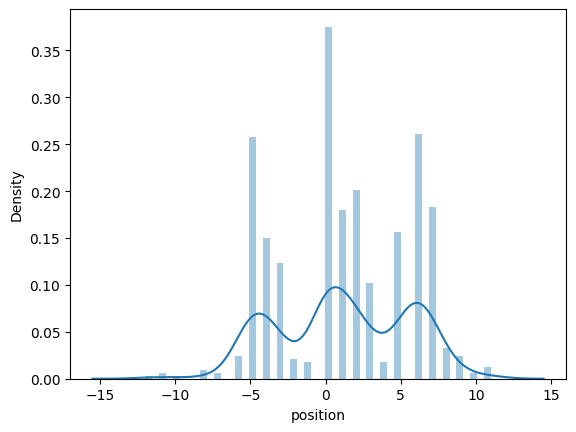

In [38]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution

In [39]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[  0,   1,   0,   1,   0,   0,   5,   0,   0,   0,   1,   1,   0,
          0,   0,   0],
       [  0,   1,   0,   1,   0,   0,  82,   1,   0,   2,   0,   0,   1,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  47,   1,   2,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   1,   0,   1,   0,   0,  35,   0,   0,   0,   0,   1,   0,
          0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   6,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   2,   0,   1,   0,   0, 118,   1,   0,   4,   0,   0,   0,
          2,   0,   0],
       [  0,   1,   0,   1,   0,   0,  58,   1,   0,   0,   0,   0,   2,
          0,   0,   0],
       [  0,   4,   1,   1,   0,   0,  62,   0,   0,   0,   0,   0,   2,
          1,   0,   0],
       [  0,   1,   0,   0,   0,   0,  30,   0,   0,   1,   0,   0,   1,
          1,   0,   0],
       [  0,   0,   0,   1,   